In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.cuda.empty_cache()

random_seed = 0
torch.manual_seed(random_seed)

In [2]:
n_epochs = 15
batch_size_train = 64
batch_size_test = 500

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

torch.Size([500, 1, 28, 28])


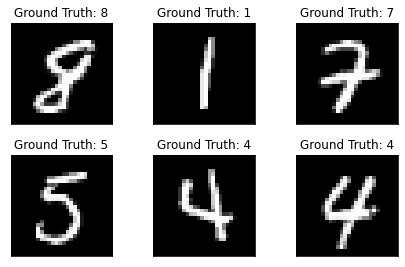

In [4]:
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [189]:
#network flowchart:
#input vector --- random initialized weights ---> hyperdimensional vecotor ---> one_hot_net l1 ---> ...ln... ---> sigmoid/softmax output
#One hot net

class One_hot_op(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A, W, epsilon):
        Z = torch.matmul(W, A)
        ctx.Z = Z
        ctx.A = A
        ctx.W = W
        ctx.epsilon = epsilon
        ret = Z > epsilon
        #print(ret[1:10][1:10])
        return ret.float()

    @staticmethod
    def backward(ctx, dL_dA):
        step = ctx.Z > ctx.epsilon
        step = step.float()
        dL_dZ = dL_dA * step 
        
        dZ_dW = torch.transpose(ctx.A, 0,1)
        dZ_dW = torch.sign(dZ_dW)
        dZ_dA = torch.transpose(ctx.W, 0,1)
        dZ_dA = torch.sign(dZ_dA)
        dA = torch.matmul(dZ_dA,dL_dZ)
        dW = torch.matmul(dL_dZ,dZ_dW)
        return dA, dW, None


class One_hot_layer(nn.Module):
    def __init__(self, in_dim, out_dim, initialization_f, epsilon):
        super(One_hot_layer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.epsilon = epsilon
        self.initialization_f = initialization_f
        initialized_weight = initialization_f(out_dim, in_dim)
        self.weight = nn.Parameter(initialized_weight, requires_grad = True)
        self.op = One_hot_op
        
    def __str__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_dim) + ',' \
               + str(self.out_dim) + ')'
        
    def forward(self, A):
        #print(self.weight[:3][:3])
        return self.op.apply(A, self.weight, self.epsilon)

class Linear_noise_op(torch.autograd.Function):
    @staticmethod
    def forward(ctx, W, noise):
        ctx.noise = noise
        return W

    @staticmethod
    def backward(ctx, dW):
        #print("go")
        #print(dW.shape)
        return apply_gaussian_noise(dW, ctx.noise, device = dW.device), None
    
class Linear(nn.Module):
    def __init__(self,in_dim,out_dim,initialization_f = None,device = torch.device("cuda:0")):
        super(Linear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.device = device
        self.weight = nn.Parameter(torch.Tensor(out_dim, in_dim), requires_grad = True)
        self.bias = nn.Parameter(torch.zeros(out_dim,1), requires_grad = True)
        self.reset_parameters()
    
    def __str__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_dim) + ',' \
               + str(self.out_dim) + ')'
        
    def reset_parameters(self):
        stdv = 1. / self.weight.size(1) ** 1 / 2
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
        
    def forward(self, X, noise = None, grad_noise = None):
        #print(self.__class__.__name__, self.weight[:2,:2])
        
        if grad_noise is not None and grad_noise != 0:
            W = Linear_noise_op.apply(self.weight, grad_noise)
            B = Linear_noise_op.apply(self.bias, grad_noise)
        else:
            W = self.weight
            B = self.bias
        
        
        if noise is None or noise == 0:
            return torch.matmul(W, X) + B
        else:
            return torch.matmul(apply_gaussian_noise(W, noise, device = self.device), X) + apply_gaussian_noise(B, noise, device = self.device)
        '''
        #return torch.matmul(self.weight, X) + self.bias
        if noise is None or noise == 0:
            return torch.matmul(self.weight, X) + self.bias
        else:
            return torch.matmul(apply_gaussian_noise(self.weight, noise, device = self.device), X) + apply_gaussian_noise(self.bias, noise, device = self.device)
        '''
class One_hot_net(nn.Module):
    def __init__(self, in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon, n_layers=2, layer_size_factor=[1, 5], dropout=[-1, 0.5]):
        super(One_hot_net, self).__init__()
        self.layers = nn.ModuleList()
        self.in_dim = in_dim
        feature_len = int(in_dim * encoder_multiplier)
        self.feature_len = feature_len
        self.n_layers=n_layers
        self.layer_size_factor=layer_size_factor
        self.dropout=dropout
        self.epsilon = epsilon
        self.n_class = n_class
        self.f_encoder = f_encoder
        self.f_initializer = f_initializer
        for i in range(n_layers):
            if dropout[i] > 0:
                self.layers.append(nn.Dropout(dropout[i]))
            if i < n_layers - 1:
                self.layers.append(
                    One_hot_layer(int(feature_len // layer_size_factor[i]), int(feature_len // layer_size_factor[i + 1]), f_initializer, epsilon))
        #self.tail = nn.Linear(int(feature_len // layer_size_factor[-1]), n_class)
        self.tail = Linear(int(feature_len // layer_size_factor[-1]), n_class, f_initializer)
        self.out = nn.LogSoftmax(dim = 0)
    
    def flatten(self, X):
        return X.view(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])

    def forward(self, X):
        X = self.flatten(X)
        X = torch.transpose(X, 0, 1)
        #X = self.f_encoder.apply_wnoise(X, sd = 0.5)
        X = self.f_encoder.apply(X)
        for layer in self.layers:
            X = layer(X)
        #X = torch.transpose(X, 0, 1)
        #X = apply_binary_noise(X, 0.05)
        X = self.tail(X, noise = 0, grad_noise = 0)
        return self.out(X).T

class toy_Net(nn.Module):
    def __init__(self):
        super(toy_Net, self).__init__()
        self.fc2 = Linear(784, 10)
        self.out = nn.LogSoftmax(dim = 0)
    def flatten(self, X):
            return X.view(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
    def forward(self, x):
        x = self.flatten(x)
        x = x.T
        x = (x > -0.4).float()
        x = self.fc2(x, noise = 0)
        return self.out(x).T
    
class toy_Net2(nn.Module):
    def __init__(self):
        super(toy_Net2, self).__init__()
        self.fc1 = Linear(784, 300)
        self.fc2 = Linear(300, 10)
        self.out = nn.LogSoftmax(dim = 0)
    def flatten(self, X):
            return X.view(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
    def forward(self, x):
        x = self.flatten(x)
        x = x.T
        x = self.fc1(x, noise = 0, grad_noise = 0)
        x = nn.ReLU()(x)
        x = self.fc2(x, noise = 0, grad_noise = 0)
        return self.out(x).T
    
class toy_Net3(nn.Module):
    def __init__(self):
        super(toy_Net3, self).__init__()
        self.fc1 = Linear(784, 400)
        self.fc2 = Linear(400, 100)
        self.fc3 = Linear(100, 10)
        self.out = nn.LogSoftmax(dim = 0)
    def flatten(self, X):
            return X.view(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
    def forward(self, x):
        x = self.flatten(x)
        x = x.T
        x = self.fc1(x, noise = 0.5, grad_noise = 1)
        x = nn.ReLU()(x)
        x = self.fc2(x, noise = 0.5, grad_noise = 1)
        x = nn.ReLU()(x)
        x = self.fc3(x, noise = 0.5, grad_noise = 1)
        return self.out(x).T

In [190]:
# noise 
def apply_gaussian_noise(tensor, sd, device = torch.device("cuda:0")):
    tensor = tensor + (sd)*torch.randn(*tuple(tensor.shape)).to(device)
    return tensor

def apply_binary_noise(tensor, p, device = torch.device("cuda:0")):
    #change 1 entries to 0
    tensor = tensor * (torch.rand(*tuple(tensor.shape))>(p/2)).float().to(device)
    #change 0 entries to 1
    tensor = tensor + (torch.rand(*tuple(tensor.shape))>(1-p/2)).float().to(device)
    return torch.sign(tensor)

#a = [[1,1,0,0,1,1], [1,1,0,0,1,1], [1,1,0,0,1,1]]
#a = torch.tensor(a)
#print((torch.rand(*tuple(a.shape))<(0.1/2)).float())
#print(a)
#print(apply_binary_noise(a, 0.1, device = torch.device("cpu")))

In [191]:
#initializers and encoders
def uniform_initializer(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-2, b=2).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-2, b=2)

class simple_encoder():
    def __init__(self, out_dim, in_dim):
        self.W = uniform_initializer(out_dim, in_dim)
        
    def apply(self, X):
        #print(X.shape)
        #print(self.W.shape)
        return torch.matmul(self.W, X)
    
class simple_encoder_wthreshold():
    def __init__(self, out_dim, in_dim, epsilon, cuda = True):
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.device = torch.device("cuda:0") if cuda else torch.device("cpu")
        self.epsilon = epsilon
        
    def apply(self, X):
        return (torch.matmul(self.W, X) > self.epsilon).float()
    
    def apply_wnoise(self, X, sd):
        return (torch.matmul(apply_gaussian_noise(self.W, sd, device = self.device), X) > self.epsilon).float()
    
class non_linear_encoder():
    def __init__(self, out_dim, in_dim, activation, cuda = True):
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.activation = activation
        
    def apply(self, X):
        #print(X.shape)
        #print(self.W.shape)
        return self.activation((torch.matmul(self.W, X)))

In [222]:
parameters = {
    'in_dim': 784,
    'n_class': 10,
    'f_encoder': simple_encoder_wthreshold(784//2, 784, 10e-3),
    'f_initializer': uniform_initializer,
    'encoder_multiplier': 0.5,
    'epsilon': 10e-3,
    'n_layers': 1,
    'layer_size_factor': [1, 1, 1],
    'dropout': [0.3, -1, -1]
}

In [223]:
device = torch.device("cuda:0")
model1 = One_hot_net(parameters['in_dim'], parameters['n_class'], parameters['f_encoder'], parameters['encoder_multiplier'], parameters['f_initializer'], parameters['epsilon'], parameters['n_layers'], parameters['layer_size_factor'], parameters['dropout']).to(device)
#model1 = toy_Net2().to(device)
#model1 = toy_Net3().to(device)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.5)
#optimizer1 = torch.optim.SGD([{'params': model1.layers.parameters(), 'lr': 0.01}, {'params': model1.tail.parameters(), 'lr': 0.01}], lr=0.01, momentum=0.5)

In [224]:
from torchsummary import summary
summary(model1, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                    [-1, 2]               0
            Linear-2                    [-1, 2]           3,930
        LogSoftmax-3                    [-1, 2]               0
Total params: 3,930
Trainable params: 3,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [225]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [226]:
def train(epoch, model, optimizer, trainloader, log_interval = 10, device = torch.device("cuda:0")):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #torch.save(model.state_dict(), '/results/model.pth')
            #torch.save(optimizer.state_dict(), '/results/optimizer.pth')
    return model, optimizer


In [227]:
def test(model, test_loader, device = torch.device("cuda:0")):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [228]:
model_name = "base_net1"
acc_max = test(model1, test_loader)
for epoch in range(1, n_epochs + 1):
    train(epoch, model1, optimizer1, train_loader)
    acc = test(model1, test_loader)
    if acc > acc_max:
        acc = acc_max
        print()
        print("--- saving model for best accuracy ---")
        #torch.save(model1.state_dict(), 'results/'+model_name+'.pth')
        #torch.save(optimizer1.state_dict(), 'results/'+model_name+'_optimizer.pth')
        print("--- saving finished ---")
        print()


Test set: Avg. loss: 2.3031, Accuracy: 1154/10000 (11.5%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303139
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.120127
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.021809
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.766909
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.677190
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.539331
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.448591
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.380113
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.353810
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.303342
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.311778
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.184278
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.187466
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.152380
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.124464
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.048178
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.017401
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.011562
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.980637
Train Epoch: 1 [121

Text(0, 0.5, 'negative log likelihood loss')

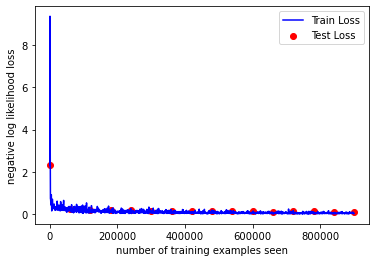

In [221]:
## fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:
#torch.save(model1.state_dict(), 'results/base_model.pth')
#torch.save(optimizer1.state_dict(), 'results/base_optimizer.pth')

In [ ]:
# sanity check
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
fig = plt.figure()
model1.eval()
output = model1(example_data.to(torch.device("cuda:0"))).cpu().detach()
prediction = torch.argmax(output, dim = 1)
print(prediction)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("G T: {} P: {}".format(example_targets[i], prediction[i]))
    plt.xticks([])
    plt.yticks([])